### The Pima Indians Diabetes Dataset holds valuable information for understanding and predicting diabetes onset. Derived from a real-world population study of Pima Indian women in Arizona, it contains data on various factors potentially linked to the development of diabetes, such as age, body mass index (BMI), blood glucose levels, insulin levels, family history, and pregnancy details.

### This dataset has become a benchmark for developing and evaluating machine learning algorithms for diabetes prediction. Its popularity stems from its accessibility, manageable size, and relevant mix of numerical and categorical features. Researchers use it to explore various machine learning techniques, compare model performance, and gain insights into the relationships between different factors and diabetes risk.

### While the Pima Indians Diabetes Dataset offers valuable insights, it's important to consider its limitations. It represents a specific population group and may not generalize perfectly to other demographics. Additionally, its data collection occurred several decades ago, potentially limiting its reflection of modern population health trends.

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_predict, StratifiedKFold as kf
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [80]:
df = pd.read_csv(r"C:\Users\johnm\OneDrive\Desktop\archive (22).zip")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Explore the Dataset

In [81]:
df.shape

(768, 9)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [83]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
pd.DataFrame(df.Outcome.value_counts())

,Outcome
0,500
1,268


### This dataset is inbalanced.

### Deploy Graphs to further study the data

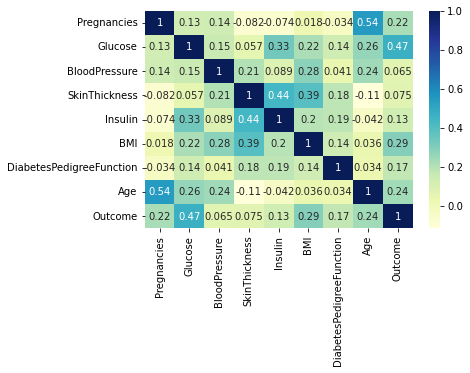

In [85]:
df.corr
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

#### We don't see any strong associations over 0.70 but there is a minor coorelation between #pregnancies and age as well as Skin Thickness and Insulin. There is also an association between glucose level and diabetes diagnosis which is to be expected.

Text(0.5, 1.0, 'Glucose vs Outcome')

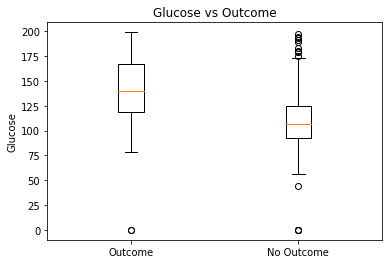

In [87]:
plt.boxplot([df[df['Outcome']==1]['Glucose'], df[df['Outcome']!=1]['Glucose']], labels = ["Outcome", "No Outcome"])
plt.ylabel('Glucose')
plt.title('Glucose vs Outcome')

#### We see that not all subjects with high glucose was diagnosed with Diabetes and the amount of outliers in the "No Outcome" boxplot shows that some data did not fit the shorter IQR.

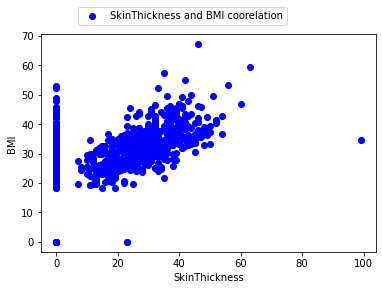

In [89]:
fig,ax=plt.subplots()
ax.scatter(df.SkinThickness, df.BMI, color="blue", label="SkinThickness and BMI coorelation")
ax.set_xlabel("SkinThickness")
ax.set_ylabel("BMI")
plt.legend(bbox_to_anchor =(0.75, 1.15), ncol = 2)


<AxesSubplot:xlabel='Pregnancies', ylabel='Age'>

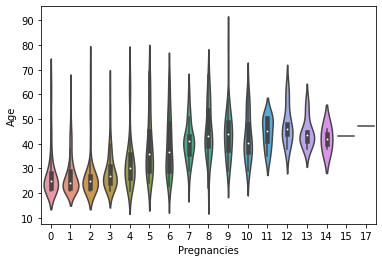

In [90]:
sns.violinplot('Pregnancies', 'Age', data= df)

### We see that increased age means increased pregnancies untill the 13th and 14th pregnancy.

Text(0.5, 1.0, 'glucose by Age')

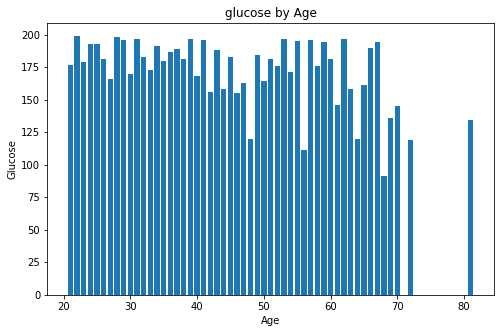

In [91]:
fig,ax=plt.subplots(figsize=(8,5))
ax.bar(df.Age, df.Glucose)
ax.set_xlabel("Age")
ax.set_ylabel("Glucose")
ax.set_title("glucose by Age")

In [92]:
df['Age'].describe()

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
25%       24.000000
50%       29.000000
75%       41.000000
max       81.000000
Name: Age, dtype: float64

In [93]:
age_ranges=np.arange(20,100,10)

In [94]:
df['Age_range']=pd.cut(x=df['Age'],bins=age_ranges)

<AxesSubplot:title={'center':'Glucose'}, xlabel='Age_range'>

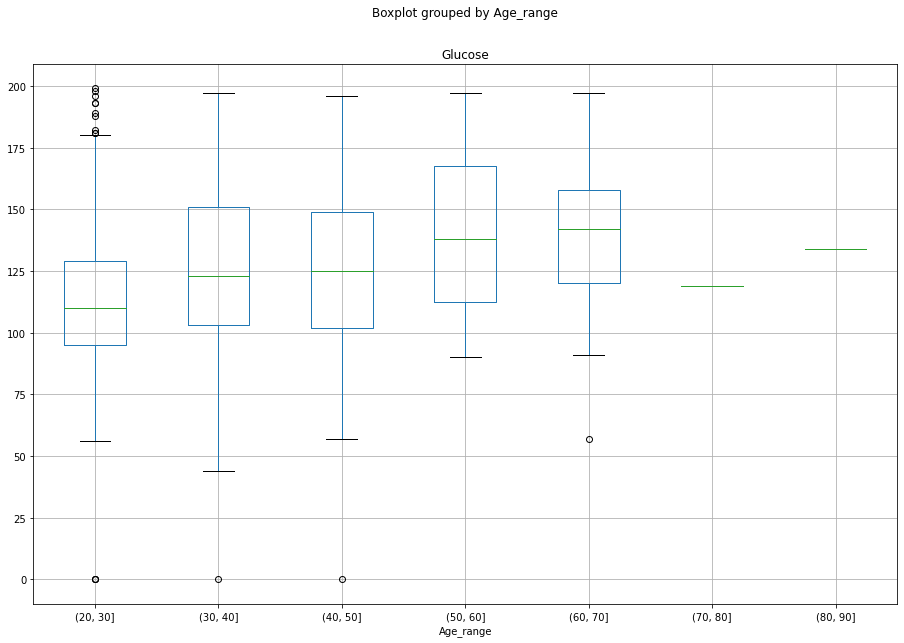

In [95]:
df.boxplot(column='Glucose',by='Age_range',figsize=(15,10))

#### We see a lower glucose level in the 20-30 year old range and higher ranges in 50-70 years.

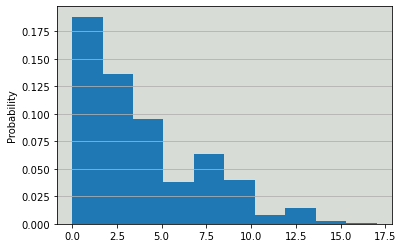

In [97]:
fig, ax = plt.subplots()#
#df.plot.kde(ax=ax, legend=False, title='Histogram: A vs. B')  
df['Pregnancies'].plot.hist(density=True, ax=ax)
ax.set_ylabel('Probability')
ax.grid(axis='y')
ax.set_facecolor('#d8dcd6')

### Train Model

In [98]:
target_col = "Outcome"
x = df.drop([target_col,'Age_range'], axis=1).values
y = df[target_col].values

In [99]:
from sklearn.model_selection import train_test_split
x_df_train, x_df_test, y_df_train, y_df_test = train_test_split(x,y, test_size = 0.3)

In [100]:
x_df_train.mean(0)

array([  3.86592179, 120.22160149,  69.50465549,  20.56610801,
        79.37243948,  32.13370577,   0.46225698,  33.59031657])

In [101]:
x_df_train.std(0)

array([  3.44262534,  31.5896239 ,  19.42527287,  15.80195773,
       114.85882771,   7.61568262,   0.3065903 ,  12.1038238 ])

### Scale the Data

In [102]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = StandardScaler()
x_df_train = sc.fit_transform(x_df_train) #mean=0, std=1
x_df_test = sc.transform(x_df_test)

In [103]:
x_df_train.mean(0)

array([ 3.92816340e-17, -3.96951249e-17,  2.37653886e-16, -5.78887238e-18,
       -1.73252681e-16, -2.43463433e-15,  5.71134284e-16, -1.06680648e-16])

In [104]:
x_df_train.std(0)

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [105]:
x_df_train.shape

(537, 8)

In [106]:
y_df_train.shape

(537,)

In [107]:
x = x_df_train
y = y_df_train

In [108]:
x.shape

(537, 8)

In [109]:
x_df_test.shape

(231, 8)

### Logistic Regression

In [110]:
# logisitic model
#x_df_test = x_df_test.reshape(-1, 1)
lr = LogisticRegression(max_iter=800)
y_lr =cross_val_predict(lr,x , y, cv=None)
print('Logistic AUC: {:.3f}'.format(roc_auc_score(y, y_lr)))

Logistic AUC: 0.707


### Support Vector Machine

In [111]:
# SVM
from sklearn.svm import SVC
svm = SVC(kernel = 'rbf', random_state = 0)
y_svm = cross_val_predict(svm, x, y, cv=None, groups=y)
print('SVC AUC: {:.3f}'.format(roc_auc_score(y, y_svm)))

SVC AUC: 0.680


### Decision Tree

In [112]:
# decision tree model
tree = DecisionTreeClassifier(max_depth=8)
y_tree = cross_val_predict(tree, x, y, cv=None, groups=y)
print('Tree AUC: {:.3f}'.format(roc_auc_score(y, y_tree)))


Tree AUC: 0.726


### Random Forest

In [113]:
# Random Forest
rf = RandomForestClassifier(n_estimators=50, max_depth=8)
y_rf = cross_val_predict(rf, x, y, cv=None, groups=y)
print('RF AUC: {:.3f}'.format(roc_auc_score(y, y_rf)))

RF AUC: 0.715


### XGBoost

In [114]:
# xgboost (boosting)
xgb = XGBClassifier(n_estimators=15, max_depth=20, eval_metric ='logloss', use_label_encoder=False)
y_xgb = cross_val_predict(xgb, x, y, cv=None, groups=y)
print('XGB AUC: {:.3f}'.format(roc_auc_score(y, y_xgb)))

XGB AUC: 0.715


### Plotting FPR Vs. TPR of the ML models

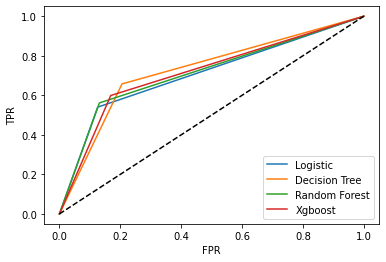

In [115]:
# plot ROC curve for different models
fpr, tpr, _ = roc_curve(y, y_lr)
plt.plot(fpr, tpr, label='Logistic') 

fpr, tpr, _ = roc_curve(y, y_tree)
plt.plot(fpr, tpr, label='Decision Tree')

fpr, tpr, _ = roc_curve(y, y_rf)
plt.plot(fpr, tpr, label='Random Forest')

fpr, tpr, _ = roc_curve(y, y_xgb)
plt.plot(fpr, tpr, label='Xgboost')

plt.plot([0,1], [0,1],'k--');
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend();

### Decision tree had the highest accuracy and best FPR to TPR values. Lets look at the Classification Report.

In [42]:
model=XGBClassifier(n_estimators=15, max_depth=20, eval_metric ='logloss', use_label_encoder=False)
model.fit(x,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=20, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=15, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [43]:
y_test_pred=model.predict(x_df_test)
y_test_pred

array([0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [44]:
y_df_test

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int64)

### Classification Report

In [46]:
from sklearn.metrics import classification_report, confusion_matrix 
cm = confusion_matrix(y_df_test,y_test_pred)
print('Confusion matrix: \n',cm)
print('Classification report: \n',classification_report(y_df_test,y_test_pred))

Confusion matrix: 
 [[128  25]
 [ 35  43]]
Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.84      0.81       153
           1       0.63      0.55      0.59        78

    accuracy                           0.74       231
   macro avg       0.71      0.69      0.70       231
weighted avg       0.73      0.74      0.74       231



### Implementing GridSearch for XGBoost

In [49]:
from sklearn.model_selection import GridSearchCV
## gridsearch allows us to find the best parameters for any model

In [50]:
params={'n_estimators':[20,50,100,200],'max_depth':[5,10,50]}
model=XGBClassifier()
grid_search=GridSearchCV(model,params,cv=5)

In [51]:
grid_search.fit(x,y)

[15:55:54] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:55:54] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:55:54] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:55:54] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [53]:
grid_search.best_params_

{'max_depth': 50, 'n_estimators': 50}

### Second round of XGBoost using the First round's best parameters

In [54]:
params={'n_estimators':[80,100,120],'max_depth':[8,10,12]}
model=XGBClassifier()
grid_search=GridSearchCV(model,params,cv=5)
grid_search.fit(x,y)

[15:56:27] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:27] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:27] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:27] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [55]:
grid_search.best_params_

{'max_depth': 10, 'n_estimators': 120}

In [56]:
grid_search.cv_results_

{'mean_fit_time': array([0.05655651, 0.0676291 , 0.0763041 , 0.0618454 , 0.07073812,
        0.07899575, 0.062045  , 0.07410727, 0.08488131]),
 'std_fit_time': array([0.00210906, 0.00270518, 0.00229619, 0.00209057, 0.00227916,
        0.0019343 , 0.0013181 , 0.00509196, 0.00337303]),
 'mean_score_time': array([0.0009975 , 0.00179577, 0.00119681, 0.00159593, 0.00139666,
        0.00159574, 0.00119724, 0.0015964 , 0.00159607]),
 'std_score_time': array([2.78041453e-07, 3.99232605e-04, 3.99255881e-04, 4.88772332e-04,
        4.88811281e-04, 4.88519261e-04, 3.98803196e-04, 4.88188863e-04,
        4.88305431e-04]),
 'param_max_depth': masked_array(data=[8, 8, 8, 10, 10, 10, 12, 12, 12],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[80, 100, 120, 80, 100, 120, 80, 100, 120],
              mask=[False, False, False, False, False, False, False,

In [57]:
y_test_pred2=grid_search.best_estimator_.predict(x_df_test)

### Confusion Matrix and Classification report of final round of GridSearch

In [58]:
from sklearn.metrics import classification_report, confusion_matrix 
cm = confusion_matrix(y_df_test,y_test_pred2)
print('Confusion matrix: \n',cm)
print('Classification report: \n',classification_report(y_df_test,y_test_pred2))

Confusion matrix: 
 [[125  28]
 [ 34  44]]
Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.82      0.80       153
           1       0.61      0.56      0.59        78

    accuracy                           0.73       231
   macro avg       0.70      0.69      0.69       231
weighted avg       0.73      0.73      0.73       231



## In Conclusion:

### Two rounds of GridSearch gave us the best results for XGboost, this is better than decision tree. We were able to achieve a precision bwtween .61 to .79. This is great for an imbalanced dataset. We must remember that accuracy is not as important in datasets that are not balanced.

### Despite these limitations, the Pima Indians Diabetes Dataset remains a valuable tool for researchers and developers in the field of diabetes prediction. By analyzing its data, researchers can improve our understanding of diabetes risk factors and develop more accurate and effective prediction models, ultimately contributing to better preventive measures and personalized healthcare strategies.